#**Analyzing ESPN's Fantasy Basketball Algorithm and Projecting Player Performance** 
by Dino Ambrosi, Casey McGonigle and Mickey Piekarski

##**Abstract**
The objective of this project is to understand what fantasy basketball scores are actually measuring, which factors tend to influence them, and how they can best be predicted. We will do an exploratory data analysis in which we compare the model to advanced player performance statistics in order to understand its meaning, perform a principle component analysis on the metrics that constitute the fantasy points algorithm, and analyze the effect of factors such as home court advantage and opposing defensive strength on its outcomes. Using the insights from our EDA we will form a linear model to predict fantasy basketball scores which will be trained on 2 seasons of game by game data and tested on a third. 

##**Introduction**

####**How does fantasy basketball work?**
The premise of fantasy sports is to form a roster of players and receive points based on their real-life performance. Many people play league-based fantasy in which a league of 6-12 teams take turns drafting players at the start of the season and then play each other head-to-head each week, but recently daily fantasy sports (DFS) has been on the rise. In DFS, players are valued with a certain price based on their projected performance in that day's game, and DFS players are allowed a certain amount of virtual currency that they can spend to form a roster of players. Though fantasy sports started as a fun game to play against friends, it has quickly turned into multi-billion dollar industry, with the two largest DFS sites, draftkings and fanduel each being valued at over a billion dollars. 

In daily fantasy sports, the name of the game is beating the projections made by the hosting service. By purchasing players who outperform the pricetag that is set by fanduel or draftkings, users can make a pretty penny, but in order to do this effectively, you need to understand what fantasy points are actually measuring, which factors can influence them, and how they can best be predicted. 
####**The Fantasy Points Algorithm**
ESPN, which runs the largest fantasy basketball league in the world, defines a players fantasy total as:

FPTS = FG - FGA + FT - FTA + TRB + AST + STL + BLK - TOV + PTS

where: 
*   FG = Field goals made
*   FGA = Field goals attempted
*   FT = Free throws made
*   FTA = Free throws attempted
*   TRB = Total rebounds
*   AST = Assists
*   BLK = Blocks
*   TOV = Turnovers
*   PTS = Points scored

####**Our Data**

All of the data used in this project has been downloaded or webscraped off of basketball-reference.com. We will build our projections by training our model on game-by-game statistics of the top 100 fantasy scorers from the 2016-17 and 2017-18 seasons, and test it on the top 100 scorers from the 2018-19 season. Below are functions that find the top 100 fantasy players for a particular season, webscrape their box scores for each game they played in that season, and aggregate the boxscores of all of the players into one dataframe that we can use for analysis. 

In [0]:

import numpy as np
import seaborn as sns
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
import statistics
import sklearn.utils

In [0]:
def fantasy_points(table):
#Fantasy points algorithm
  return table['PTS'].astype(np.float)+table['FG'].astype(np.float)-table['FGA'].astype(np.float)+table['FT'].astype(np.float)
  -table['FTA'].astype(np.float)+table['TRB'].astype(np.float)+table['AST'].astype(np.float)+table['BLK'].astype(np.float)
  +table['STL'].astype(np.float)-table['TOV'].astype(np.float)
def standard_units(ser):
  return (ser - np.mean(ser))/np.std(ser)
def getTop100PlayerIDs(url):
  """Receives the url of a csv containing player stat totals from a certain year, finds the top 100 fantasy scorers and returns their playerIDs"""
  df1 = pd.read_csv(url)
  df1 = df1.rename(columns = {'PTS▼':'PTS'})
  df1['Fantasy Totals'] = fantasy_points(df1)
  df2 = df1.sort_values(by = 'Fantasy Totals', ascending = False).iloc[0:100].reset_index()
  top100Players = df2['Player'].values.copy()
  for i in range(100):
    top100Players[i] = top100Players[i].split('\\')[1]
  return top100Players
def getFantPoints(url):
  """Receives the url of a csv containing player stat totals from a certain year, returns their player IDS and their fantasy totals"""
  df1 = pd.read_csv(url)
  df1 = df1.rename(columns = {'PTS▼':'PTS'})
  df1['FPTS'] = fantasy_points(df1)
  df2 = df1.sort_values(by = 'FPTS', ascending = False).reset_index()
  df2['Player'] = [player.split('\\')[1] for player in df1['Player']]
  return df2
def get_game_by_game_df(Id, Rk, season):
  """Takes a player's id and season (2017-18 season would be passed in as '2018') and returns their box score for each game they played in that season with fantasy points
  and the defensive rating of their opponent (adjusted for opponsing offensive strength, in standard units)"""
  url = 'https://www.basketball-reference.com/players/h/'+Id+'/gamelog/'+season
  df = pd.read_html(url)[7]
  df['Season'], df['Player'], df['Rk'] = [int(season), Id, Rk]
  remove = ['dnd', 'Inactive', 'Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended']
  df = df[~df['FG'].isin(remove)]
  df = df[df['G'] != 'G']
  df = df.rename(columns = {df.columns[5]: 'H/A'}).replace({np.nan: 'Home', '@': 'Away'})
  #Filtering out games with less than 20 minutes played
  df = df[df['MP'].str.split(':', expand = True)[0].astype(float) > 20]
  df['FPTS'] = fantasy_points(df)
  df['FPTS SU'] = standard_units(df['FPTS'])
  dates = []
  for i in range(len(df)):
    dates.append(datetime.datetime.strptime(df['Date'].values[i], '%Y-%m-%d'))
  df['Date'] = dates
  restdays = [5]
  for i in np.arange(1,len(df)):
    days = (df['Date'].values[i] - df['Date'].values[i-1]).astype('timedelta64[D]')
    days = days / np.timedelta64(1, 'D')
    if int(days) > 5:
      restdays.append(5)
    else:
      restdays.append(int(days))
  df['Rest Days'] = restdays
  df = df.reset_index()
  df = df[['Player','Rk','G','Date', 'Rest Days', 'H/A', 'Opp','MP','FG','FGA','FT','FTA','TRB','AST','STL','BLK','TOV','PTS','FPTS', 'FPTS SU']]
  return df
def get_season_df(ids, season):
  """Concatenates all of the boxscore DFs for each player passed in"""
  count = 0
  dfs = []
  for i in range(100):
    dfs.append(get_game_by_game_df(ids[i], i+1, season))
  return pd.concat(dfs, ignore_index=True)
abbrev_map = {"Utah Jazz":"UTA",'Boston Celtics':'BOS','San Antonio Spurs':'SAS','Philadelphia 76ers':'PHI','Toronto Raptors':'TOR','Houston Rockets':'HOU','Miami Heat':'MIA','Portland Trail Blazers':'POR','Oklahoma City Thunder':'OKC','Detroit Pistons':'DET','Golden State Warriors':'GSW','Los Angeles Lakers':'LAL','Indiana Pacers':'IND','New Orleans Pelicans':'NOP','Washington Wizards':'WAS','Charlotte Hornets':'CHA','Dallas Mavericks':'DAL','Milwaukee Bucks':'MIL','Orlando Magic':'ORL','Los Angeles Clippers':'LAC','Atlanta Hawks':'ATL','Brooklyn Nets':'BKN','New York Knicks':'NYK','Chicago Bulls':'CHI','Memphis Grizzlies':'MEM','Denver Nuggets':'DEN','Sacramento Kings':'SAC','Minnesota Timberwolves':'MIN','Cleveland Cavaliers':'CLE','Phoenix Suns':'PHX'}

In [0]:
# will refer to 2018/19 season as 2019
ids2019 = getTop100PlayerIDs('https://raw.githubusercontent.com/dino-ambrosi/Data100GradProject/master/PlayerTotals2019.csv')
ids2018 = getTop100PlayerIDs('https://raw.githubusercontent.com/dino-ambrosi/Data100GradProject/master/PlayerTotals2018.csv')
ids2017 = getTop100PlayerIDs('https://raw.githubusercontent.com/dino-ambrosi/Data100GradProject/master/PlayerTotals2017.csv')

In [0]:
"""Produces df with all boxscores of top 100 players from each of the last 3 seasons""";
df17 = get_season_df(ids2017, '2017')
df18 = get_season_df(ids2018, '2018')
df19 = get_season_df(ids2019, '2019')
last_3_seasons = pd.concat([df17, df18, df19], ignore_index = True)
# last_3_seasons.to_csv()

In [0]:
"""Imports the file created above from github""";
# last_3_seasons = pd.read_csv('https://raw.githubusercontent.com/dino-ambrosi/Data100GradProject/master/last_3_seasons.csv')

The above code is finding each of the top 100 fantasy scorers from each of the last 3 seasons, scraping their box scores for each game they played in a certain season, and cleaning it to make a dataframe that we can use for analysis. The df that is initially returned for each player is shown in the following cell.

In [0]:
pd.read_html('https://www.basketball-reference.com/players/h/curryst01/gamelog/2019')[7].head(5)

,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1,2018-10-16,30-216,GSW,NaN,OKC,W (+8),1,36:37,11,20,.550,5,9,.556,5,5,1.000,0,8,8,9,1,0,3,4,32,27.5,+15
1,2,2,2018-10-19,30-219,GSW,@,UTA,W (+1),1,37:07,13,24,.542,5,9,.556,0,1,.000,1,3,4,8,2,0,4,2,31,23.4,-3
2,3,3,2018-10-21,30-221,GSW,@,DEN,L (-2),1,39:13,10,23,.435,6,16,.375,4,4,1.000,0,4,4,6,0,0,2,4,30,19.7,+3
3,4,4,2018-10-22,30-222,GSW,NaN,PHO,W (+20),1,29:40,11,18,.611,6,13,.462,1,2,.500,0,4,4,8,2,0,3,0,29,26.2,+18
4,5,5,2018-10-24,30-224,GSW,NaN,WAS,W (+22),1,31:35,15,24,.625,11,16,.688,10,10,1.000,0,4,4,3,0,1,2,1,51,41.8,+19


For each table we have removed unnecessary columns, calculated the fantasy total for each game (in normal and standard units), made a "Home vs. Away" column, calculated how many days of rest the player has had before each game (if a player had more than 5 days of rest we simply counted it as 5), and added the players id and fantasy rank in that season.

In [0]:
get_game_by_game_df('curryst01', 7, '2019').head(5)

,Player,Rk,G,Date,Rest Days,H/A,Opp,MP,FG,FGA,FT,FTA,TRB,AST,STL,BLK,TOV,PTS,FPTS,FPTS SU
0,curryst01,7,1,2018-10-16,5,Home,OKC,36:37,11,20,5,5,8,9,1,0,3,32,28.0,0.610725
1,curryst01,7,2,2018-10-19,3,Away,UTA,37:07,13,24,0,1,4,8,2,0,4,31,20.0,-0.094656
2,curryst01,7,3,2018-10-21,2,Away,DEN,39:13,10,23,4,4,4,6,0,0,2,30,21.0,-0.006483
3,curryst01,7,4,2018-10-22,1,Home,PHO,29:40,11,18,1,2,4,8,2,0,3,29,23.0,0.169862
4,curryst01,7,5,2018-10-24,2,Home,WAS,31:35,15,24,10,10,4,3,0,1,2,51,52.0,2.726870


##**Part 1: Exploratory Data Analysis**

####**Analyzing the meaning of fantasy points**
When people play fantasy basketball for the first time, their gut usually tells them to pick the players that they consider to be "the best" which is usually derived from name recognition, team success, and per game averages of the three most commonly referenced stats: points, rebounds and assists. But what does it actually mean to be the best in basketball, and how well does that map to being the best in fantasy basketball? To answer this question let's take a look at some advanced statistics, and see how correlated player performance is under those metrics to the fantasy basketball algorithm.

In [0]:
# importing the fantasy totals for all players in 2018 and restricting data set to top 60% of scorers
FantTotals18 = getFantPoints('https://raw.githubusercontent.com/dino-ambrosi/Data100GradProject/master/PlayerTotals2018.csv')
FantTotals18['FPTS/MP'] = FantTotals18['FPTS'] / FantTotals18['MP']
fantTotals18 = FantTotals18[['Player', 'FPTS', 'FPTS/MP']]
lowerbound = np.percentile(fantTotals18['FPTS'], 40)
fantTotals18 = fantTotals18[fantTotals18['FPTS'] >= lowerbound]
scoringPlayers = set(fantTotals18['Player'].values)

In [0]:
#Cleaning advanced stats data and restricting it to only contains players in the fantasy totals table
ADV18 = pd.read_csv('https://raw.githubusercontent.com/dino-ambrosi/Data100GradProject/master/AdvancedMetrics2018.csv')
adv18 = ADV18.copy()
adv18['Player'] = [player.split('\\')[1] for player in ADV18['Player']]
adv18 = adv18[['Player','Tm','PER','WS/48','BPM','VORP']]
dupPlayers = adv18[adv18['Tm'] == 'TOT']['Player'].values
dropList = []
for i in range(len(adv18)):
  if (adv18.Player[i] in dupPlayers and adv18.Tm[i] != 'TOT') or adv18.Player[i] not in scoringPlayers:
    dropList.append(i)
Adv18 = adv18.drop(dropList)
fantAndAdv18 = fantTotals18.merge(Adv18, how = 'inner', on = 'Player').drop('Tm', axis = 1)
fantAndAdv18.head(5).round(2)

,Player,FPTS,FPTS/MP,PER,WS/48,BPM,VORP
0,jamesle01,2017.0,0.79,28.6,0.22,9.6,8.9
1,hardeja01,1923.0,0.71,29.8,0.29,10.9,8.3
2,davisan02,1916.0,0.63,28.9,0.24,5.2,4.9
3,westbru01,1841.0,0.67,24.7,0.17,8.2,7.5
4,antetgi01,1661.0,0.62,27.3,0.21,5.8,5.4


The table above contains advanced metrics for the top 60% of fantasy point producers in the 2018 season. Let's take a look at them one-by-one:

**Player Efficiency Rating (PER)**
PER, created by statistician John Hollinger, attempts to boil down all of a players contribution into one number. It measures a players per-minute performance adjusted for pace of play. The formula is very long and complex, if you are curious you can read more about it [here](https://www.basketball-reference.com/about/per.html)

**Win Shares per 48 Minutes (WS/48)**
WS/48 is derived from the win shares, a metric developed by the prolific baseball analyst Bill James, it attempts to give credit to individual players based on their contributions to team success such that the sum of a teams win shares over an entire season will approximate their win total. The formula, as one might expect, is quite complicated. You can read about its derivation [here](https://www.basketball-reference.com/about/ws.html).

**Box Score Plus/Minus (BPM)**
BPM attempts to estimate a players performance relative to the league average. The creator of BPM admits openly that it *could* be a better stat, but it only considers statistics that are historically available so that it can be used to compare players across decades. More information is available [here](https://www.basketball-reference.com/about/bpm.html)

**Value Over Replacement Player (VORP)**
VORP is closely related to BPM, with the main difference being that it accounts for how much a player plays whereas BPM is purely a rate statistic. The formula for VORP is simple: 

(BPM + 2)\*(% of minutes played)\*(team games/82)

VORP is described in greater detail [here](https://www.basketball-reference.com/about/bpm.html#vorp)

#####**Correlations between fantasy points and advanced statistics**
Below is a set of plots that show the correlation between all of the metrics we have discussed. Notice that the advanced metrics have a much stronger correlation with each other than they do with fantasy points (especially VORP and BPM, which makes sense because VORP is derived from BPM), which shows that a players fantasy total isn't an great proxy for their actual value. Of the advanced metrics, fantasy points correlates the strongest to VORP, likely because fantasy points and VORP are the only two statistics we are considering that aren't adjusted for the number of minutes or possessions that a player logs. It is surprising that fantasy points per minute (FPTS/MP) correlates worse with the rate statistics than FPTS does.

<Figure size 576x576 with 0 Axes>

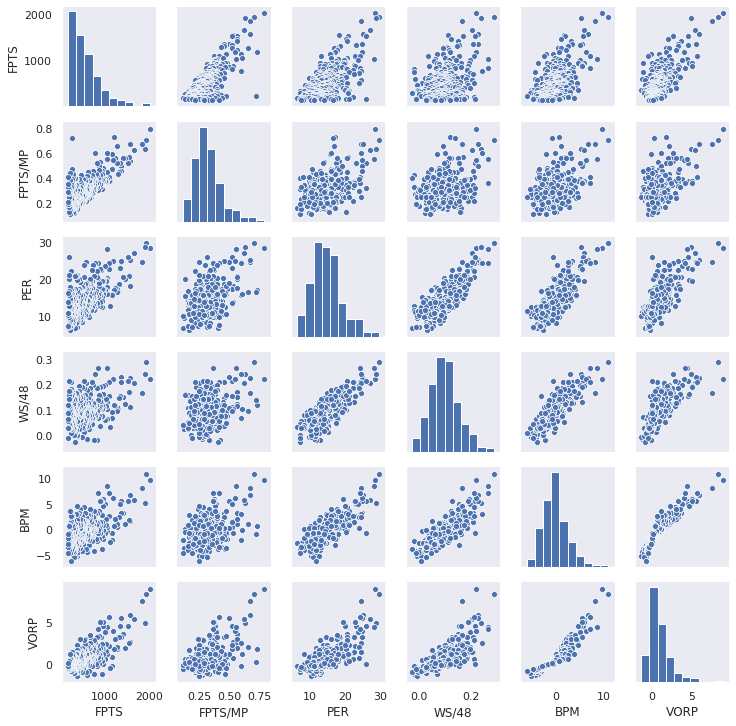

In [0]:
plt.figure(figsize=(8, 8))
sns.set()
sns.set_style('dark')
g = sns.pairplot(fantAndAdv18);
g.fig.set_size_inches(10,10)

In [0]:
#A matrix of the correlation coefficients between each of the columns:
fantAndAdv18.corr().round(2)

,FPTS,FPTS/MP,PER,WS/48,BPM,VORP
FPTS,1.00,0.77,0.64,0.40,0.58,0.73
FPTS/MP,0.77,1.00,0.48,0.32,0.45,0.57
PER,0.64,0.48,1.00,0.82,0.78,0.74
WS/48,0.40,0.32,0.82,1.00,0.83,0.74
BPM,0.58,0.45,0.78,0.83,1.00,0.94
VORP,0.73,0.57,0.74,0.74,0.94,1.00


#####**Adjusting the weights of the fantasy points algorithm**
The advanced statistics that we are citing are calculated using complicated, lengthy formulas that are difficult to interpret. In order to understand them in simpler terms, we will run a linear regression for each advanced metric using the players season totals in the stats that constitute the fantasy algorithm as our features, and fit the model to their scores according to the advanced metric under consideration. The regression will output weights that are difficult to interpret because the advanced metrics are measured on scales that are far different than fantasy totals (the heighest WS/48 score recorded in 2018 was 0.29). In order to resolve this issue we will put the weights in standard units centered around 1 to better show their relationship to the fantasy algorithm. In doing so, we will get a sense of how the basic box score stats are valued in the various metrics, as well as what the fantasy algorithm *should* look like in order to better represent player value.

In [0]:
FantTotals18 = FantTotals18[['Player', 'FG','FGA','FT','FTA','TRB','AST','STL','BLK','TOV','PTS']].iloc[:325]
FantAdvMODEL18 = FantTotals18.merge(Adv18, how = 'inner', on = "Player")
FantAdvMODEL18.head()

,Player,FG,FGA,FT,FTA,TRB,AST,STL,BLK,TOV,PTS,Tm,PER,WS/48,BPM,VORP
0,jamesle01,651,1449,624,727,389,630,126,50,315,2191,CLE,28.6,0.221,9.6,8.9
1,hardeja01,780,1462,495,598,832,174,115,193,162,2110,HOU,29.8,0.289,10.9,8.3
2,davisan02,857,1580,388,531,709,747,116,71,347,2251,NOP,28.9,0.241,5.2,4.9
3,westbru01,742,1402,487,641,753,361,109,106,223,2014,OKC,24.7,0.166,8.2,7.5
4,antetgi01,621,1415,493,538,325,481,77,27,206,1962,MIL,27.3,0.207,5.8,5.4


In [0]:
from sklearn.linear_model import LinearRegression
def get_coeffs(metric):
  X = FantTotals18.drop(['Player'], axis = 1)
  y = FantAdvMODEL18[metric].astype(np.float)
  reg = LinearRegression().fit(X, y)
  coefs = reg.coef_
  coeff_array = [metric]
  coeff_array.extend(standard_units(coefs) + 1)
  coeff_floats = [metric]
  for i in np.arange(1, len(coeff_array)):
    coeff_floats.append(float(coeff_array[i]))
  return coeff_floats

In [0]:
#finding coefficients from the regression
PER_coeffs, WS48_coeffs, BPM_coeffs, VORP_coeffs = get_coeffs('PER'), get_coeffs('WS/48'), get_coeffs('BPM'), get_coeffs('VORP')
fant_coeffs = ['FPTS']
fant_coeffs.extend([1,-1,1,-1,1,1,1,1,-1,1])

In [0]:
#building table of weights
avg_array = [statistics.mean(k) for k in zip(PER_coeffs[1:],WS48_coeffs[1:],BPM_coeffs[1:])]
coeffs_array = [PER_coeffs, WS48_coeffs, BPM_coeffs, VORP_coeffs, fant_coeffs]
plot_array = [PER_coeffs[1:], WS48_coeffs[1:], BPM_coeffs[1:], VORP_coeffs[1:], fant_coeffs[1:], avg_array]
metrics = ['PER', 'WS/48', 'BPM', 'VORP', 'FPTS']
plot_metrics = ['PER', 'WS/48', 'BPM', 'VORP', 'FPTS','Average']
colors = ['paleturquoise', 'navajowhite', 'lightsteelblue', 'palegreen', 'crimson', 'royalblue']
plot_scale = [int(1),int(1),int(1),int(1),int(1),int(1)]
cols = ['Metric', 'FG', 'FGA', 'FT', 'FTA', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']
plot_cols = ['FG', 'FGA', 'FT', 'FTA', 'Rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers', 'Points']
coeff_DF = pd.DataFrame(coeffs_array, columns = cols)
coeff_DF = coeff_DF.set_index(coeff_DF.Metric.values).drop('Metric', axis = 1)
coeff_DF.round(2)

,FG,FGA,FT,FTA,TRB,AST,STL,BLK,TOV,PTS
PER,1.55,-0.90,0.91,0.82,0.44,0.92,1.87,1.87,-0.17,2.69
WS/48,1.10,-0.71,-0.09,1.52,0.40,0.85,2.15,1.83,0.30,2.64
BPM,1.43,-0.31,2.97,-0.33,0.52,0.24,1.96,0.78,0.91,1.83
VORP,1.05,-0.51,3.02,-0.04,0.36,0.39,1.52,1.51,0.64,2.05
FPTS,1.00,-1.00,1.00,-1.00,1.00,1.00,1.00,1.00,-1.00,1.00


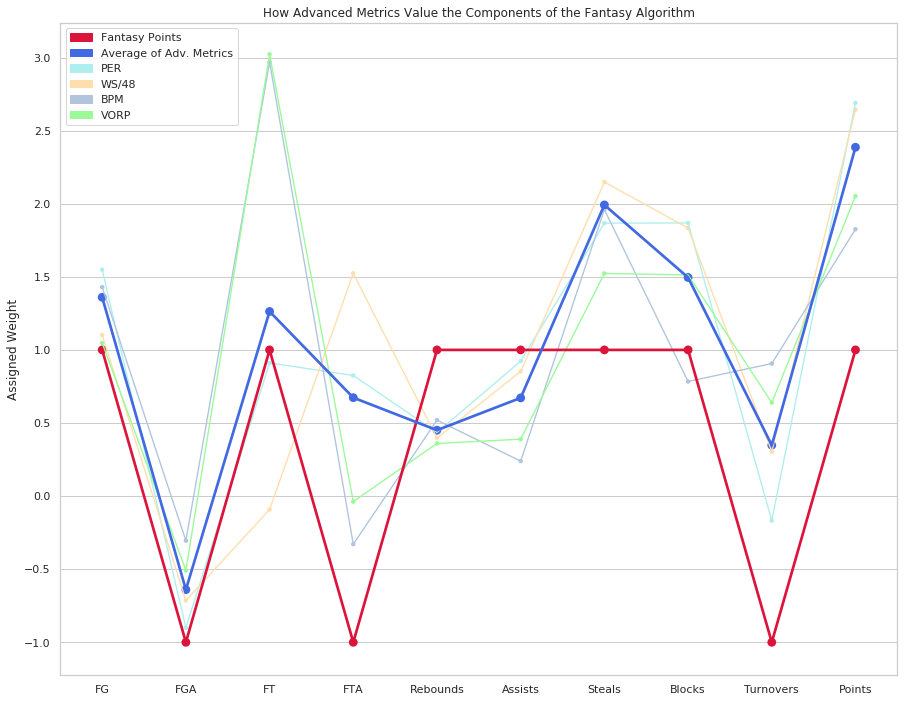

In [0]:
#Creating a point plot of the above information
plt.figure(figsize = (15, 12))
sns.set()
sns.set_style('whitegrid')
for i in range(6):
  if i < 4:
    sns.pointplot(x = plot_cols, y = plot_array[i], label = plot_metrics[i], color = colors[i], scale = .5)
  else:
    sns.pointplot(x = plot_cols, y = plot_array[i], label = plot_metrics[i], color = colors[i], scale = 1)
c_patch = mpatches.Patch(color='crimson', label='Fantasy Points')
rb_patch = mpatches.Patch(color = 'royalblue', label = 'Average of Adv. Metrics')
pt_patch = mpatches.Patch(color='paleturquoise', label='PER')
nw_patch = mpatches.Patch(color='navajowhite', label = 'WS/48')
lsb_patch = mpatches.Patch(color = 'lightsteelblue', label = 'BPM')
pg_patch = mpatches.Patch(color= 'palegreen', label = 'VORP')
plt.legend(handles=[c_patch, rb_patch, pt_patch, nw_patch, lsb_patch, pg_patch]);
plt.ylabel('Assigned Weight');
plt.title('How Advanced Metrics Value the Components of the Fantasy Algorithm');

**Note:** due to its high correlation (.94) with BPM, VORP was not considered when computing the average of the advanced metrics.
#####**Insights**
At first glance, some of the weights seem to be inappropriate. According to the average of the weights assigned to PER, WS/48, and BPM (the blue line in the visualization) a turnover should be given roughly the same value as rebound, which should be given less value than a free throw attempt. It's likely that the reason for these seemingly anomalous weights is that the best players simply have the ball in their hands more (not only in terms of minutes played, but also per minute played or per possession) and therefore have more opportunities to turn the ball over or get the to the freethrow line. It should be noted that PER, which heavily emphasizes efficient scoring and ball protection does in fact have a negative weight for turnovers, as well as the lowest weight (- 0.9) for field goals attempted, which makes quite a lot of sense. 

Some of the most meaningful insight lies in the evaluation of rebounds, assists, steals, and blocks. Our regression shows us that by assigning these stats the same value, the fantasy algorithm reinforces a false equivalence that most casual fans are prone to when they look at a box score. It makes sense that a rebound is far less valuable than a steal, as a steal is a definitive end to the opposing teams possession, whereas a rebound is either a continuation of an offensive possession, or the end an oppossing possession that occurs *after* a shot has been taken. One may think that an assist should be valued much higher than our regression shows because it is guaranteed to lead to points, but there are many other ways to help your team score other than assisting (such as grabbing an offensive rebound, setting a screen, or putting another teammate in an ideal position to assist someone else) which dilute its value. 

#####**The Key Takeaway**
Both the lack of strong correlations between fantasy points and the most respected advanced player metrics, and the deviation of the weights assigned to the fantasy algorithm by regression show us that fantasy points are *not* a good proxy for player value. In simpler terms, if at any point you get hired as a general manager for an NBA team do not build your roster by trying to acquire the best fantasy players. Instead, fantasy points are an overly simplified way to evaluate player performance which makes them accessible to the casual fan. 

###**Next Step: Analyzing the Impact of the Opposing Defense**

This cell defines the functions we use to eventually compile dataframes containing team defensive statistics from the seasons we are considering (will be labeled d19, d18, and d17). These functions create dataframes of tables from Basketball Reference that we have loaded into our shared github repo. It is not imperative that you have an in depth understanding of what's going on in this cell.

In [0]:
def create_dStats(year):
  """Importing miscelaneous statistics from the given year"""
  #Note: year should be in the form #### for the second year of the season
  #So the 2018-2019 season would just be written as 2019
  miscStats = pd.read_csv('https://raw.githubusercontent.com/caseymcgon/Data100GradProject/master/MiscStats' + str(year) + '.csv')
  miscStats.columns = miscStats.iloc[0]
  miscStats = miscStats[1:]
  miscStats["Team"] = miscStats["Team"].apply(lambda x:str(x).replace("*",""))
  dStats = miscStats.copy()
  dStats['Team'] = dStats['Team'].map(abbrev_map)
  dStats = dStats.drop(columns = {"Rk","DRtg", "Age", "W", "L", "PW", "PL", "MOV", "SOS", "SRS", "ORtg", "ORB%",  "NRtg", "FTr", "3PAr", "TS%", "DRB%", "Arena", "Attend.", "Attend./G" })
  dStats.columns = ["Team", "Pace", "drop", "drop", "drop", "opp_eFG%", "opp_TOV%", "opp_FT/FGA"]
  dStats = dStats.drop("drop", axis = 1)
  return dStats

def create_p100p(year):
  """Importing Per 100 Possession Stats from the given year"""
  Per100Poss = pd.read_csv('https://raw.githubusercontent.com/caseymcgon/Data100GradProject/master/Per100Poss' + str(year) + '.csv')
  Per100Poss["Team"] = Per100Poss["Team"].apply(lambda x:str(x).replace("*",""))
  p100p = Per100Poss.copy()
  p100p['Team'] = p100p['Team'].map(abbrev_map)
  p100p = p100p.drop(columns = {"Rk", "G","MP", "FG", "3P", "3PA","FGA", "FT", "FTA", "3P%", "FG%", "2P", "2PA", "2P%", "FT%", "ORB", "DRB", "AST", "STL", "BLK", "TOV", "PF", "PTS" })
  return p100p

def create_dRatings(year):
  """Importing Defensive Ratings for the given year"""
  defRatings = pd.read_csv('https://raw.githubusercontent.com/caseymcgon/Data100GradProject/master/DefensiveRatings' + str(year) + '.csv')
  defRatings.columns = defRatings.iloc[0]
  defRatings = defRatings[1:]
  defRatings['Team'] = defRatings['Team'].map(abbrev_map)
  defRatings = defRatings.filter(['Team','DRtg/A'], axis=1)
  return defRatings

def create_TRB(year, p100p):
  """Importing Opponent Per 100 Possession Stats from 2018-19"""
  """Using those stats to calculate a team's Total Rebounding %"""
  oppPer100Poss = pd.read_csv('https://raw.githubusercontent.com/caseymcgon/Data100GradProject/master/OppPer100Poss' + str(year) + '.csv')
  oppPer100Poss["Team"] = oppPer100Poss["Team"].apply(lambda x:str(x).replace("*",""))
  op100p = oppPer100Poss.copy()
  op100p['Team'] = op100p['Team'].map(abbrev_map)
  op100p = op100p.drop(columns = {"Rk", "G","MP", "FG", "3P", "3PA","FGA", "FT", "FTA", "3P%", "FG%", "2P", "2PA", "2P%", "FT%", "ORB", "DRB", "AST", "STL", "BLK", "TOV", "PF", "PTS" })
  op100p.columns = ["Team", "opp_TRB"]
  TRB = op100p.merge(p100p,  on = "Team", how = "outer")
  TRB["TRB%"] = TRB["opp_TRB"]/(TRB["opp_TRB"]+TRB["TRB"])
  TRB.sort_values("TRB%")
  #Note: a lower TRB% means the team is better at Team Rebounding (ie. opponents struggle rebounding) -- High TRB% == opponents rebound easily
  TRB = TRB.drop(columns = {"opp_TRB", "TRB"}).sort_values("TRB%")
  return TRB

def create_totalD(dStats, dRatings, TRB):
  """Creating the Final total Defensive Metrics table from the given year"""
  d = dStats.merge(TRB, on = "Team")
  d = d.merge(dRatings, on = "Team")
  d = d.sort_values("DRtg/A")
  d['Pace'] = d["Pace"].astype(np.float)
  d['opp_eFG%'] = d['opp_eFG%'].astype(np.float)
  d['opp_TOV%'] = d["opp_TOV%"].astype(np.float)
  d['opp_FT/FGA'] = d["opp_FT/FGA"].astype(np.float)
  d['TRB%'] = d["TRB%"].astype(np.float)
  d['DRtg/A'] = d["DRtg/A"].astype(np.float)
  d['DRtg SU'] = standard_units(d['DRtg/A'])
  d["deanO"] = (.4 * d["opp_eFG%"]) + (.25 * d["opp_TOV%"]) + (.2 * d["TRB%"]) + (.15 * d["opp_FT/FGA"])
  d["deanO SU"] = standard_units(d["deanO"])
  return d

This cell compiles the d17, d18, and d19 dataFrames by merging the dataFrames created in the function definitions of the last cell.

In [0]:
def team_defense(year):
  #Note: year should be in the form #### for the second year of the season
  #So the 2018-2019 season would just be written as 2019
  dStats = create_dStats(year)
  p100p = create_p100p(year)
  dRatings = create_dRatings(year)
  TRB =  create_TRB(year, p100p)
  totalD = create_totalD(dStats, dRatings, TRB)
  return totalD

d17 = team_defense(2017)
d18 = team_defense(2018)
d19 = team_defense(2019)

This following cell loads one of our d## dataFrames to show just what stats we are tracking. Here's a breakdown of why we chose each metric.

**Pace = Team's Average # of Possessions Per Game**. If the team has more possessions, so do their opponents. We want to know: are those added possessions correlated with more fantasy points?

**opp_eFG% = Opponent's Effective Field Goal Percentage**, meaning it is the opponent's shooting percentage, factoring in that a 3 pointer is worth 1.5x as much as a 2 pointer. We want to know: is a higher effective field goal percentage correlated with more fantasy points?

**opp_TOV% = Opponent's Turnover Percentage**. We want to know: Is a team that forces more turnovers correlated with lower fantasy points for opposing players?

**opp_FT/FGA = Opponent's Free Throws per Field Goal Attempted**, essentially a measure of how often a team gets to the free throw line. We want to know: is a team that allows opponents to get to the free throw line often correlated with higher fantasy points for those opposing players?

**TRB% = Team Rebounding Percentage**. Every rebound this team grabs is a lost opportunity for a rebound for opposing players. We want to know: Is a higher TRB% correlated with lower fantasy points for opposing players?

**DRtg/A = Defensive Rating Adjusted for the opposing offense**. In layman's terms its the opponent's points per 100 possesions adjusted for how good the opposing offense is. We want to know: if a team has a higher DRtg/A (and thus allows more points per 100 possessions), is that correlated with higher fantasy points for their opponents?

**DRtg SU = Defensive Rating in Standard Units** (for the entire league)

**deanO = "Dean Oliver's Four Factors of Basketball Success"** which he chalks basketball success up to 40% dependent on shooting (opp_eFG%), 25% dependent on turnovers (opp_TOV%), 20% dependent on rebounding (TRB%), and 15% dependent on free throws (opp_FT/FGA). We want to know: does a higher Dean Oliver 'score' correlate to lower fantasy points against by opposing players?

**deanO SU = deanO in Standard Units** (for the league)

In [0]:
d18.head()

,Team,Pace,opp_eFG%,opp_TOV%,opp_FT/FGA,TRB%,DRtg/A,DRtg SU,deanO,deanO SU
3,UTA,95.7,0.506,14.0,0.190,0.490374,104.24,-2.086778,3.828975,1.184818
6,BOS,96.0,0.495,13.0,0.191,0.496718,104.75,-1.877279,3.575994,-0.047990
7,SAS,95.0,0.507,13.2,0.170,0.490110,105.23,-1.680103,3.626322,0.197266
4,PHI,99.8,0.492,12.6,0.218,0.470917,105.81,-1.441849,3.473683,-0.546560
8,POR,96.5,0.503,11.7,0.193,0.485746,106.79,-1.039281,3.252299,-1.625393


This cell simply calculates the correlation coefficient (r) between a (top 100 fantasy) player's points in a given game and the quality of the defense they're playing against (using the metrics used as features in our d## dataFrames)

By all defensive metrics we studied, we found very low correlation (r < .1) between one's opponent's team defence and one's fantasy points against those teams

In [0]:
def corr_fpts_opp(year, idsList, dDF):
  """year, idsList, and dDF should be of the form '2019', 'ids2019', and 'd19' respectively  """
  #note: correlation doesn't care if statistics are in Standard Units or not
  coeff, coeff1, coeff2, coeff3, coeff4, coeff5, coeff6, coeff7 = 0, 0, 0, 0, 0, 0, 0, 0

  for guy in idsList:
    game = get_game_by_game_df(guy, 1, str(year))
    game = game.filter(['Player','Opp', "FPTS SU"], axis=1)
    game = game.merge(dDF, left_on = "Opp", right_on = "Team")
    coeff += np.corrcoef(game['FPTS SU'], game["DRtg SU"])[0][1]
    coeff1 += np.corrcoef(game['FPTS SU'], game["Pace"])[0][1]
    coeff2 += np.corrcoef(game['FPTS SU'], game["opp_TOV%"])[0][1]
    coeff3 += np.corrcoef(game['FPTS SU'], game["opp_FT/FGA"])[0][1]
    coeff4 += np.corrcoef(game['FPTS SU'], game["TRB%"])[0][1]
    coeff5 += np.corrcoef(game['FPTS SU'], game["opp_eFG%"])[0][1]
    coeff6 += np.corrcoef(game["FPTS SU"], game["deanO"])[0][1]
    coeff7 += np.corrcoef(game["FPTS SU"], game["deanO SU"])[0][1]
  

  print("These are the correlation coefficients between Fantasy Points (in Standard Units) and each attribute in " + str(year) )
  print("DRtg SU:", np.round(coeff/len(ids2019), decimals = 3))
  print("")
  print("Pace:", np.round(coeff1/len(ids2019), decimals = 3))
  print("")
  print("opp_TOV%:", np.round(coeff2/len(ids2019), decimals = 3))
  print("")
  print("opp_FT/FGA:", np.round(coeff3/len(ids2019), decimals = 3))
  print("")
  print("TRB%:", np.round(coeff4/len(ids2019), decimals = 3))
  print("")
  print("opp_eFG%:", np.round(coeff5/len(ids2019), decimals = 3))
  print("")
  print("deanO:", np.round(coeff6/len(ids2019), decimals = 3))
  print("deanO SU:", np.round(coeff7/len(ids2019), decimals = 3))

corr_fpts_opp(2018, ids2018, d18)

These are the correlation coefficients between Fantasy Points (in Standard Units) and each attribute in 2018
DRtg SU: 0.068

Pace: 0.014

opp_TOV%: -0.012

opp_FT/FGA: 0.024

TRB%: 0.045

opp_eFG%: 0.047

deanO: -0.01
deanO SU: -0.01


This cell plots a given team's defensive stat (We've chosen to display Defensive Rating in Standard Units) vs. the fantasy points scored by top 100 players on a game-by-game basis against that team

Note: a lower defensive rating means the team lets up less points per 100 possessions -- ie. lower defensive rating = better defense

Text(0.5, 1.0, 'DRtg SU v. Fantasy Points for the top 100 fantasy players in 2019')

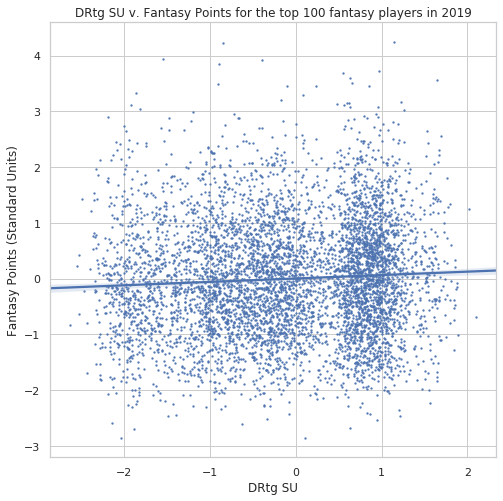

In [0]:
def plot_stat_v_fpts(year, idsList, dDF, stat):
  """year, idsList, and dDF should be of the form '2019', 'ids2019', and 'd19' respectively """
  """stat should be one of the following: "DRtg SU", "Pace", "opp_TOV%", "opp_FT/FGA", "TRB%", "opp_eFG%", "deanO", "deanO SU" (quotes included) """
  #this function allows us to plot a given defensive metric against fantasy points allowed for the top 100 fantasy scorers
  top_fpts = []
  other_stat = []
  for guy in idsList:
    game = get_game_by_game_df(guy, 1, str(year))
    game = game.filter(['Player','Opp', "FPTS SU"], axis=1)
    game = game.merge(dDF, left_on = "Opp", right_on = "Team")
    top_fpts.extend(f for f in game["FPTS SU"])
    other_stat.extend(d for d in game[stat])
  
  return top_fpts, other_stat
  
top_fpts, other_stat = plot_stat_v_fpts(2018, ids2018, d18, "DRtg SU") 
  
  
plt.figure(figsize=(8, 8))
sns.regplot(other_stat + np.random.normal(0,.2, len(other_stat)), top_fpts + np.random.normal(0,.2, len(top_fpts)), scatter_kws={'s':2})
plt.xlabel("DRtg SU")
plt.ylabel("Fantasy Points (Standard Units)")
plt.title("DRtg SU v. Fantasy Points for the top 100 fantasy players in 2019")

Finally, lets run an A/B test to see if this (admitedly small) correlation coefficient between fantasy points (SU) and Defensive Rating (SU) is statistically significant

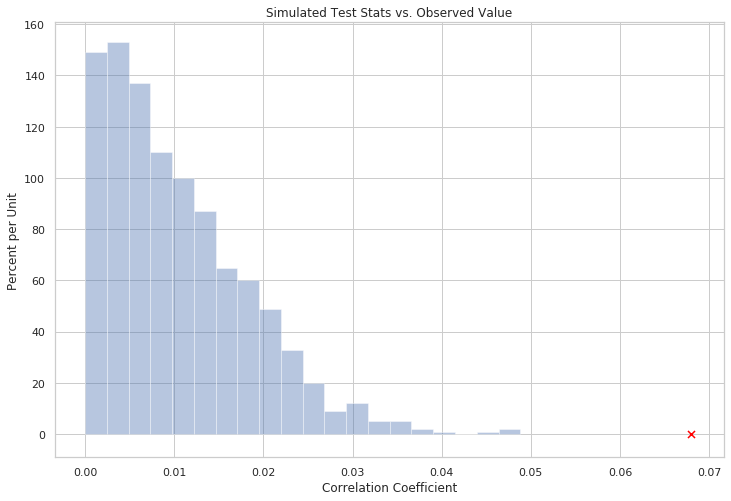

In [0]:
fpts_drtg = pd.DataFrame()
fpts_drtg["Fantasy Points"] = top_fpts
fpts_drtg["Defensive Rating"] = other_stat

import random
test_stat = []
ab = fpts_drtg.copy()
for i in range(1000):
  col = []
  shuffle = ab.copy()
  shuffle = sklearn.utils.shuffle(shuffle)
  ab['Fantasy Points'] = shuffle['Fantasy Points'].values
  test_stat.append(abs(np.corrcoef(ab["Fantasy Points"], ab["Defensive Rating"])[0][1]))

plt.figure(figsize = (12,8))
plt.title('Simulated Test Stats vs. Observed Value')
plt.ylabel
sns.set()
sns.set_style('darkgrid')
sns.axes_style('darkgrid')
sns.distplot(test_stat, bins = 20, kde=False)
plt.scatter(x = 0.068, y= 0, s = 50, marker = 'x', c = 'red')
plt.xlabel("Correlation Coefficient");
plt.ylabel("Percent per Unit");

It appears our correlation coefficient is statisticallys significant! (Even if its not a very strong correlation)


> **Done showing weak correlation between FPTS & DRTG**

> ### **Next Step: how defensive performances against a certain position is correlated with fantasy points at that position**




For a given year, this create_posList() function returns 6 things. 

The first 3 are dataFrames that compile all fantasy points (in Standard Units) and opponents (on a game-by-game basis) for all centers, forwards, and guards in the top 100 fantasy scorers of that year.

The next 3 are lists of the the top 100 fantasy players of a year broken down by their position (center, forward, guard)

In [0]:
def create_posList(year, idsList):
  #Note: year should be in the form #### for the second year of the season
  #So the 2018-2019 season would just be written as 2019
  #idsList should be of the form 'ids2019'
  date = str(year-1) + '-' + str(year)[2:]
  
  players = pd.read_csv('https://raw.githubusercontent.com/caseymcgon/Data100GradProject/master/PlayerTotals' + date + '.csv')
  name = players["Player"]
  players["Player"] = [name[i].split("\\")[1] for i in range(len(name))]

  pos = players[['Player', 'Pos']].copy()
  pos = pos.loc[pos["Player"].isin(idsList)]
  pos["Pos"] = pos["Pos"].replace("PG", "G").replace("SG", "G").replace("PF", "F").replace("SF", "F")

  posC = list(pos[pos["Pos"] == "C"]["Player"])
  posG = list(pos[pos["Pos"] == "G"]["Player"])
  posF = list(pos[pos["Pos"] == "F"]["Player"])

  centers = [get_game_by_game_df(posC[i], 5, str(year))[["Opp", "FPTS SU"]] for i in range(len(posC))]
  centers = pd.concat(centers)
  centers = centers.replace({'Opp':{'CHO':'CHA', 'BRK':'BKN', 'PHO':'PHX'}})
  forwards = [get_game_by_game_df(posF[i], 5, str(year))[["Opp", "FPTS SU"]] for i in range(len(posF))]
  forwards = pd.concat(forwards)
  forwards = forwards.replace({'Opp':{'CHO':'CHA', 'BRK':'BKN', 'PHO':'PHX'}})
  guards = [get_game_by_game_df(posG[i], 5, str(year))[["Opp", "FPTS SU"]] for i in range(len(posG))]
  guards = pd.concat(guards)
  guards = guards.replace({'Opp':{'CHO':'CHA', 'BRK':'BKN', 'PHO':'PHX'}})
  return centers, forwards, guards, posC, posF, posG



This pos_fpts_v_team() function returns 6 objects that will be used in the scatter_setup function in the next cell.

The first 3 objects are dataFrames of opponent's average fantasy points allowed (in SU) to given positions

The next 3 objects are the lists of all top 100 fantasy players that fall into the given position


In [0]:
def pos_fpts_v_team(year, idsList):
  """Note: those years and idsList can be changed to get different data for a different season"""
  posList = create_posList(year, idsList)
  c_fpts, f_fpts, g_fpts, posC, posF, posG = posList[0], posList[1], posList[2], posList[3], posList[4], posList[5]

  centDF = c_fpts.groupby("Opp").mean().sort_values("FPTS SU").reset_index()
  forwDF = f_fpts.groupby("Opp").mean().sort_values("FPTS SU").reset_index()
  guarDF = g_fpts.groupby("Opp").mean().sort_values("FPTS SU").reset_index()

  return centDF, forwDF, guarDF, posC, posF, posG



This next cell calls the pos_fpts_v_team(year, idsList) function that provides the parameters for our scatter_setup and actual scatterplot functions

In [0]:
centDF, forwDF, guarDF, posC, posF, posG = pos_fpts_v_team(2018, ids2018)

In [0]:
#defining position data for all three years (will be used later on)
cDF17, fDF17, gDF17, c17, f17, g17 = pos_fpts_v_team(2017, ids2017)
cDF18, fDF18, gDF18, c18, f18, g18 = pos_fpts_v_team(2018, ids2018)
cDF19, fDF19, gDF19, c19, f19, g19 = pos_fpts_v_team(2019, ids2019)

This function returns the 2 lists that we will later pass into a scatter plot.

The lists are, respectively, all the fantasy points (in SU) by a top players @ a given position for a given year and the average fantasy points allowed (in SU) by the opponent for the entire season.

Note: the lists are the same length -- that is, the same index in each list corresponds to the same game. In other words, at a given index, 1 list will contain a top 100 player's fantasy points in that game (in standard units for the player) and 1 list will contain the players' opponent's average fantasy points (in standard units) allowed to the player's position for the season

Note: we are using standard units for fantasy points because we don't want individual players' ability to be noise added to our data. For example, we don't want a team that plays in the Rockets conference to reflect higher fantasy points per game for guards simply because they play James Harden (a high scoring fantasy player) a lot. Instead, standardizing his fantasy points will allow us to see if he put up more or less fantasy points than his average against that team.

In [0]:
def scatter_setup(year, posDF, dDF, pos):
  # example perams: (2018, centDF, d18, posC)
  

  top_fpts_pos = []
  opponent = []
  for guy in pos:
    game = get_game_by_game_df(guy, 1, str(year))
    game = game.filter(['Player','Opp', "FPTS SU"], axis=1)
    game = game.merge(dDF, left_on = "Opp", right_on = "Team")
    top_fpts_pos.extend(f for f in game["FPTS SU"])
    opponent.extend(posDF[posDF["Opp"] == o]["FPTS SU"].values[0] for o in game["Opp"])

  return top_fpts_pos, opponent



This cell (and the 2 that follow it) do very similar things -- albeit for different positions. For example, this cell graphs a scatterplot between the average fantasy points allowed by a team to centers vs. the game-by-game fantasy points allowed for centers in the top 100 club against that team. The next cells do the same for forwards and gaurds respectively. These cells also print the correlation coefficient between the objects on the axes.

Correlation coefficient: 0.17851039940985508


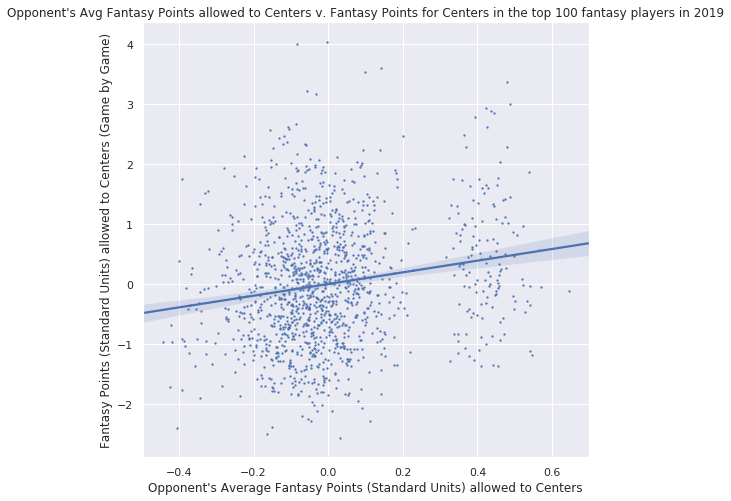

In [0]:


fpts, opp = scatter_setup(2018, centDF, d18, posC)
# example params: (2018, centDF, d18, posC)
# imperative that dates match dates in the last cell

plt.figure(figsize=(8,8))
sns.regplot(opp + np.random.normal(0,.05,len(opp)) , fpts + np.random.normal(0,.05,len(fpts)), scatter_kws={'s':2})
plt.xlabel("Opponent's Average Fantasy Points (Standard Units) allowed to Centers")
plt.ylabel("Fantasy Points (Standard Units) allowed to Centers (Game by Game)")
plt.title("Opponent's Avg Fantasy Points allowed to Centers v. Fantasy Points for Centers in the top 100 fantasy players in 2019");
print("Correlation coefficient:",np.corrcoef(opp, fpts)[0][1])


Correlation coefficient: 0.11079552513197784


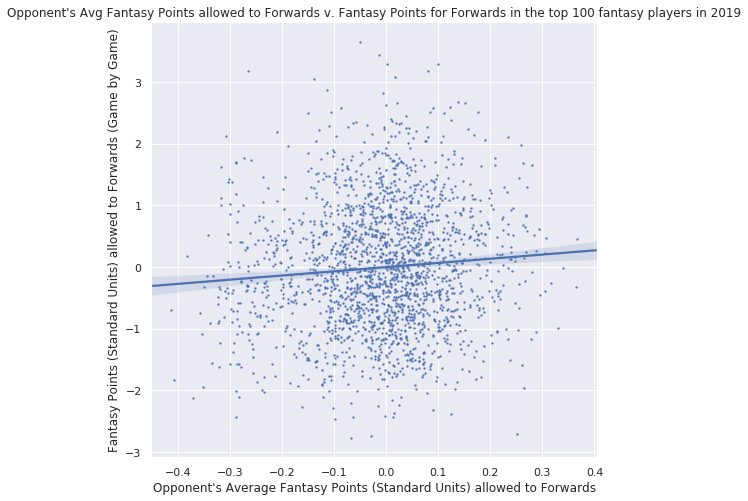

In [0]:
fpts, opp = scatter_setup(2018, forwDF, d18, posF)
# example params: (2018, centDF, d18, posC)
# imperative that dates match dates in the last cell
# imperative that 2nd param and 4th param correspond (ie forwDF & posF)



plt.figure(figsize=(8, 8))
sns.regplot(opp + np.random.normal(0,.05,len(opp)) , fpts + np.random.normal(0,.05,len(fpts)), scatter_kws={'s':2})
plt.xlabel("Opponent's Average Fantasy Points (Standard Units) allowed to Forwards")
plt.ylabel("Fantasy Points (Standard Units) allowed to Forwards (Game by Game)")
plt.title("Opponent's Avg Fantasy Points allowed to Forwards v. Fantasy Points for Forwards in the top 100 fantasy players in 2019");
print("Correlation coefficient:",np.corrcoef(opp, fpts)[0][1])


Correlation coefficient: 0.12334744983967812


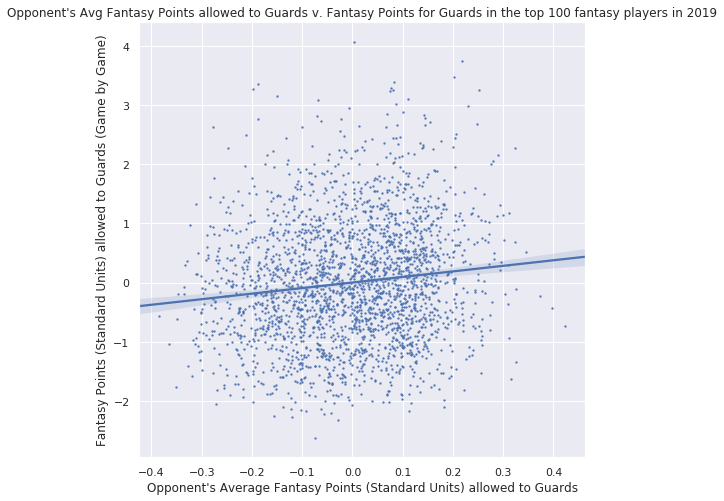

In [0]:
fpts, opp = scatter_setup(2018, guarDF, d18, posG)
# example params: (2018, centDF, d18, posC)
# imperative that dates match dates in the last cell



plt.figure(figsize=(8, 8))
sns.regplot(opp + np.random.normal(0,.05,len(opp)) , fpts + np.random.normal(0,.05,len(fpts)), scatter_kws={'s':2})
plt.xlabel("Opponent's Average Fantasy Points (Standard Units) allowed to Guards")
plt.ylabel("Fantasy Points (Standard Units) allowed to Guards (Game by Game)")
plt.title("Opponent's Avg Fantasy Points allowed to Guards v. Fantasy Points for Guards in the top 100 fantasy players in 2019");
print("Correlation coefficient:",np.corrcoef(opp, fpts)[0][1])


Finally, lets run another A/B test to see if this correlation coefficient (we'll choose the smallest of the 3 2018 stats: forwards) between fantasy points (SU) and Opponent's Average Fantasy Points (SU) is statistically significant

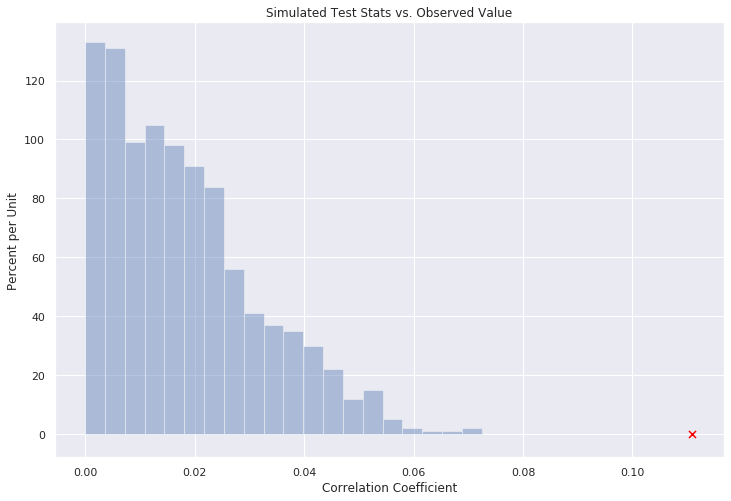

In [0]:
fpts_avg = pd.DataFrame()
fpts, avg = scatter_setup(2018, forwDF, d18, posF)
fpts_avg["Fantasy Points"] = fpts
fpts_avg["Opponent Avg FPoints"] = avg

import random
test_stat = []
aB = fpts_avg.copy()
for i in range(1000):
  col = []
  shuffle = aB.copy()
  shuffle = sklearn.utils.shuffle(shuffle)
  aB['Fantasy Points'] = shuffle['Fantasy Points'].values
  test_stat.append(abs(np.corrcoef(aB["Fantasy Points"], aB["Opponent Avg FPoints"])[0][1]))

plt.figure(figsize = (12,8))
plt.title('Simulated Test Stats vs. Observed Value')
plt.ylabel
sns.set()
sns.set_style('darkgrid')
sns.axes_style('darkgrid')
sns.distplot(test_stat, bins = 20, kde=False)
plt.scatter(x = 0.11079, y= 0, s = 50, marker = 'x', c = 'red')
plt.xlabel("Correlation Coefficient");
plt.ylabel("Percent per Unit");

Our correlation coefficient is statistically significant! (Even if its not a very strong correlation)

**KEY TAKEAWAY:**
Through observing the graphs and correlation coefficients, we can tell that there is a stronger relationship between opponent's average fantasy points allowed to a position and the fantasy points created by the top players at that position against that team than there is between players' fantasy points and any sort of normal defensive metric. This makes sense

Note: none of our correlation coefficients (r) were greater than .2, so even when we do find stronger correlation it is still a predominantly weak correlation

###**Home Court Advantage**

In [0]:
df17 = get_season_df(ids2017, '2017')
df18 = get_season_df(ids2018, '2018')

In [0]:
HA_Data = pd.concat([df17, df18], ignore_index = True)
Avg_FPTS = np.mean(HA_Data['FPTS'].values)
Home_Data = HA_Data[HA_Data['H/A'] == 'Home']
Away_Data = HA_Data[HA_Data['H/A'] == 'Away']
Home_avg = np.mean(Home_Data['FPTS'].values)
Away_avg = np.mean(Away_Data['FPTS'].values)
Home_adv = Home_avg/Avg_FPTS
Away_adv = Away_avg/Avg_FPTS
H_avg = np.round(Home_avg, decimals = 2)
A_avg = np.round(Away_avg, decimals = 2)
adv = str(np.round(Home_adv - Away_adv, decimals = 2))[3]
print(f"In 2017 and 2018, the top 100 fantasy performers scored an average of {H_avg} points at home")
print(f"as opposed to {A_avg} away, a difference of {adv}%.")

In 2017 and 2018, the top 100 fantasy performers scored an average of 14.59 points at home
as opposed to 13.82 away, a difference of 5%.


To make sure that this is actually statistically significant, lets run an AB test:

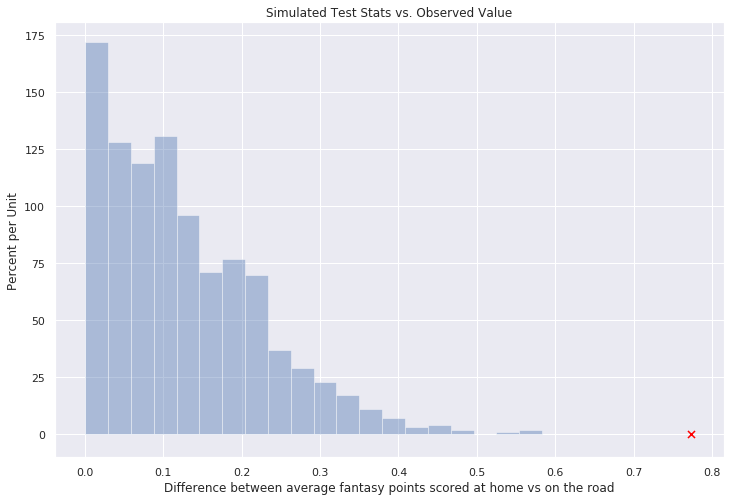

In [0]:
import random
test_stat = []
df = HA_Data.copy()
for i in range(1000):
  col = []
  shuffle = df.copy()
  shuffle = sklearn.utils.shuffle(shuffle)
  df['H/A'] = shuffle['H/A'].values
  Home = df[df['H/A'] == 'Home']
  Away = df[df['H/A'] == 'Away']
  test_stat.append(abs(np.mean(Home['FPTS'].values) - np.mean(Away['FPTS'].values)))
plt.figure(figsize = (12,8))
plt.title('Simulated Test Stats vs. Observed Value')
plt.ylabel
sns.set()
sns.set_style('darkgrid')
sns.axes_style('darkgrid')
sns.distplot(test_stat, bins = 20, kde=False)
plt.scatter(x = Home_avg - Away_avg, y= 0, s = 50, marker = 'x', c = 'red')
plt.xlabel("Difference between average fantasy points scored at home vs on the road");
plt.ylabel("Percent per Unit");

The red X correspondes to our observed value, showing us that there is in in fact a statistically significant advantage to playing at home, so we should definitely include whether a player is playing at home or away in our model.

###**Impact of Rest on Performance**

In [0]:
rest_days = last_3_seasons[['Rest Days', 'FPTS', "FPTS SU"]]
below5 = rest_days[rest_days['Rest Days']<5]

To determine the impact of rest days on fantasy performance we decided to analyze games where each player had at most four rest days. Although there were games where players had more than four rest days this was not a common case as the maximum amount of days in between two NBA games is four. If a player had five or more rest days it was likely to do with an injury, or that game occured at the beginning of the season and it is hard to predict a players performance in those cases.

Text(0.5, 0, 'Rest Days')

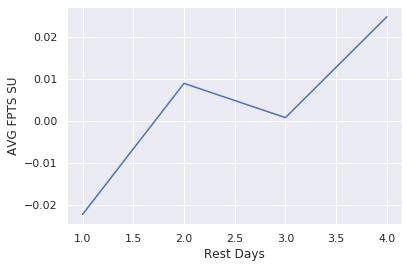

In [0]:
grouped4 =  below5[['Rest Days','FPTS SU']].groupby('Rest Days').agg(np.mean)
plt.plot(grouped4)
plt.ylabel('AVG FPTS SU')
plt.xlabel("Rest Days")


From this plot it seems as if fantasy points have a positive correlation with rest days. However this plot is misleading as the Y axis only spans.05 standard units. A boxplot is presented below for better context.

Text(0, 0.5, 'Fantasy Points (standard units)')

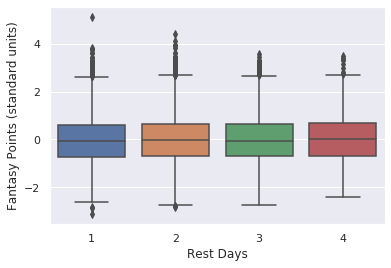

In [0]:
sns.boxplot(x = 'Rest Days', y = 'FPTS SU', data = below5)
plt.ylabel('Fantasy Points (standard units)')

From this boxplot is it evident that there does not seem to be the expected positive corrlation between rest days and fantasy performance. 

In [0]:
correlation = np.corrcoef(below5['Rest Days'],below5['FPTS SU'])[0][1]
print(correlation)

0.008381238730633914


In [0]:
correlations = []
for i in np.arange(1,1000):
  samples = np.array(below5['Rest Days'].sample(len(below5['Rest Days'])))
  fpts_su = np.array(below5['FPTS SU'])
  correlations.append(np.corrcoef(samples,fpts_su)[0][1])

p_val = (sum(correlations>correlation))/len(correlations)

print('correlation:', correlation)
print('p value:', p_val)



correlation: 0.008381238730633914
p value: 0.12412412412412413


Following the data determined from the box plots, the correlation coefficient proves there is not a strong correlation between fantasy points and rest days. Furthermore we performed an AB test to determine if the data was statistically significant and the p _value was greater than 0.05. In conclusion the correlation is not statistically significant and we will choose to ignore rest days in our analysis.

### **Analyzing Recent Performance**
Now its time to figure how a players past performance can be used to predict future fantasy scores. Specifically, we need to figure out how many of a players previous games we should use in our feature matrix when fitting our model.

To do this we will need to manipulate our original game by game dataframe for each player. As a reminder, here is how Steph Curry's 2019 season looks currently:

In [0]:
curry19 = get_game_by_game_df('curryst01', 5, '2019')
curry19

,Player,Rk,G,Date,Rest Days,H/A,Opp,MP,FG,FGA,FT,FTA,TRB,AST,STL,BLK,TOV,PTS,FPTS,FPTS SU
0,curryst01,5,1,2018-10-16,5,Home,OKC,36:37,11,20,5,5,8,9,1,0,3,32,28.0,0.610725
1,curryst01,5,2,2018-10-19,3,Away,UTA,37:07,13,24,0,1,4,8,2,0,4,31,20.0,-0.094656
2,curryst01,5,3,2018-10-21,2,Away,DEN,39:13,10,23,4,4,4,6,0,0,2,30,21.0,-0.006483
3,curryst01,5,4,2018-10-22,1,Home,PHO,29:40,11,18,1,2,4,8,2,0,3,29,23.0,0.169862
4,curryst01,5,5,2018-10-24,2,Home,WAS,31:35,15,24,10,10,4,3,0,1,2,51,52.0,2.726870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,curryst01,5,64,2019-03-31,2,Home,CHO,27:28,8,14,4,4,5,6,2,1,1,25,23.0,0.169862
64,curryst01,5,65,2019-04-02,2,Home,DEN,30:14,6,11,0,0,4,5,3,0,4,17,12.0,-0.800037
65,curryst01,5,66,2019-04-04,2,Away,LAL,29:29,3,14,0,0,10,7,1,0,2,7,-4.0,-2.210800
66,curryst01,5,67,2019-04-05,1,Home,CLE,36:06,12,21,7,7,6,7,0,1,4,40,38.0,1.492452


In [0]:
def find_pos(player):
  if player in c17 or player in c18 or player in c19:
    return 'C'
  if player in f17 or player in f18 or player in f19:
    return 'F'
  if player in g17 or player in g18 or player in g19:
    return 'G'
def find_prev(df, number):
  #adds a column do the game by game dataframe with their fantasy score from
  #a previous game, specified by the number parameter
  prev_col = []
  for i in np.arange(number, len(df)):
    prev_col.append(df['FPTS'].values[i - number])
  col_title = 'prev' + str(number)
  col = [0] * number
  col.extend(prev_col)
  trimmed_df = df.copy()
  trimmed_df[col_title] = col
  return trimmed_df
def find_multi_prev(df, number, avg):
  #adds multiple columns from previous games and a column with their average 
  #fantasy points scored in all previous games
  cols = ['Player','FPTS', 'Opp', 'H/A','pos']
  df['pos'] = find_pos(df['Player'].values[0])
  if (avg):
    season_avg = [0]
  for i in range(1, len(df)):
    prev_performances = df['FPTS'].loc[:i].values
    if (avg):
      season_avg.append(np.mean(prev_performances))
  for i in range(1, number+ 1):
    df = find_prev(df, i)
    cols.append('prev'+str(i))
  if avg:
    cols.append('prev_avg')
    df['prev_avg'] = season_avg
  df = df.loc[15:]
  df['Opp'] = df['Opp'].str.replace('CHO', 'CHA')
  df['Opp'] = df['Opp'].str.replace('PHO', 'PHX')
  df['Opp'] = df['Opp'].str.replace('BRK','BKN')
  return df[cols]

Using the methods defined in the previous cell we can alter Steph's data frame to look like this:

In [0]:
find_multi_prev(curry19, 5, True).head(10)

,Player,FPTS,Opp,H/A,pos,prev1,prev2,prev3,prev4,prev5,prev_avg
15,curryst01,12.0,MIL,Away,G,44.0,27.0,20.0,1.0,12.0,24.375000
16,curryst01,34.0,MIN,Home,G,12.0,44.0,27.0,20.0,1.0,24.941176
17,curryst01,3.0,TOR,Home,G,34.0,12.0,44.0,27.0,20.0,23.722222
18,curryst01,31.0,SAC,Away,G,3.0,34.0,12.0,44.0,27.0,24.105263
19,curryst01,15.0,MEM,Home,G,31.0,3.0,34.0,12.0,44.0,23.650000
20,curryst01,26.0,UTA,Away,G,15.0,31.0,3.0,34.0,12.0,23.761905
21,curryst01,9.0,DAL,Home,G,26.0,15.0,31.0,3.0,34.0,23.090909
22,curryst01,44.0,LAC,Home,G,9.0,26.0,15.0,31.0,3.0,24.000000
23,curryst01,6.0,LAL,Home,G,44.0,9.0,26.0,15.0,31.0,23.250000
24,curryst01,15.0,POR,Home,G,6.0,44.0,9.0,26.0,15.0,22.920000


In [0]:
def get_season_prev_df(ids, season, number, avg):
  #Finds the matrix above for the top 100 fantasy players in a certain season
  dfs = []
  for i in range(100):
    dfs.append(find_multi_prev(get_game_by_game_df(ids[i], i+1, season), number, avg))
  df = pd.concat(dfs, ignore_index=True)
  df['Season'] = season
  return df

In order to figure out how many of a player's previous games we should include in our model, let's create multiple versions of the above table containing 5, 10 and 15 previous games for each of the top 100 players in 2017 and 2018. To decide how many games we should include, we will do a 5 fold cross validation. We will also include a table containing only the players average fantasy points up to that point in the season to use as a baseline.

In [0]:
prev5_17 = get_season_prev_df(ids2017, '2017', 5, True)
prev5_18 = get_season_prev_df(ids2018, '2018', 5, True)
prev10_17 = get_season_prev_df(ids2017, '2017', 10, True)
prev10_18 = get_season_prev_df(ids2018, '2018', 10, True)
prev15_17 = get_season_prev_df(ids2017, '2017', 15, True)
prev15_18 = get_season_prev_df(ids2018, '2018', 15, True)
prev5_19 = get_season_prev_df(ids2019, '2019', 5, True)

In [0]:
prev15_19 = get_season_prev_df(ids2019, '2019', 15, True)

In [0]:
#concatenating 2017 and 2018 dataframes
prev5 = pd.concat([prev5_17,prev5_18], ignore_index= True)
prev10 = pd.concat([prev10_17,prev10_18], ignore_index=True)
prev15 = pd.concat([prev15_17,prev15_18], ignore_index= True)
avg_scoring = prev5[['Player','FPTS', 'Opp', 'H/A', 'pos', 'prev_avg']]

In [0]:
def find_prev_chunk(df, range, string):
  mean = df.iloc[:,range].mean(axis = 1)
  df[string] = mean
  return df
  

In [0]:
def find_chunks(df):
  avg5 = find_prev_chunk(df, range(5,10), 'avg5')
  avg10 = find_prev_chunk(avg5, range(10,15), 'avg10')
  avg15 = find_prev_chunk(avg10, range(15, 20), 'avg15')[['Player', 'FPTS','Opp','H/A','pos', 'avg5', 'avg10', 'avg15', 'prev_avg']]
  return avg15

In [0]:
avg15_17 = find_chunks(prev15_17)
avg15_18 = find_chunks(prev15_18)
avg15_19 = find_chunks(prev15_19)
avg15 = pd.concat([avg15_17, avg15_18])

In [0]:
def make_feature_matrix(df):
    df = df.drop(["Player", 'FPTS', 'Opp', 'H/A', 'pos'], axis = 1)
    df['Bias'] = np.ones(len(df))
    return df

In [0]:
#Running our 5-Fold cross validation
model = LinearRegression()
dfs = [avg_scoring, prev5, prev10, prev15, avg15]
cv_results = []
for df in dfs:
  cv_results.append(cross_validate(model, make_feature_matrix(df), df['FPTS'], cv=5, scoring = 'neg_mean_squared_error'))


In [0]:
#Finding the average RMSE from each cross validation
rmse_avg = np.round(np.sqrt(-1 * np.mean(cv_results[0]['test_score'])), decimals = 2)
rmse_5 = np.round(np.sqrt(-1 * np.mean(cv_results[1]['test_score'])), decimals = 2)
rmse_10 = np.round(np.sqrt(-1 * np.mean(cv_results[2]['test_score'])), decimals = 2)
rmse_15 = np.round(np.sqrt(-1 * np.mean(cv_results[3]['test_score'])), decimals = 2)
rmse_avg15 = np.round(np.sqrt(-1 * np.mean(cv_results[4]['test_score'])), decimals = 2)
print(f"The L2 loss when using a players avg number of fantasy points scored in a season up to the game under consideration is {rmse_avg}")
print("Considering 5, 10 and 15 of a players games gave us L2 losses of")
print(f"{rmse_5}, {rmse_10}, and {rmse_15} respectively")
print(f"using avg15: {rmse_avg15}")

The L2 loss when using a players avg number of fantasy points scored in a season up to the game under consideration is 8.38
Considering 5, 10 and 15 of a players games gave us L2 losses of
8.38, 8.38, and 8.37 respectively
using avg15: 8.35


Well that's rather unexpected. Factoring recent performance hardly decreased our L2 loss at all.

##**Part 2: Making the Model**

We will now use the insights that we have gained from our EDA to construct a model that predicts fantasy points. Recall that in part 1 we found that:

**Quality of the opposing defense** does not correlate as strongly as one might think with fantasy points. Of all of the metrics that we tested, adjusted defensive rating and average fantasy points allowed to certain positions produced high enough correlations to warrant being added to our model.

**Home court advantage** gives players at home a legitimate edge over those playing away, even in fantasy. We found that they scored 5% more points at home on average, which is statistically significant.

**Number of rest days** does not correlate with fantasy scoring, so we will not include it in our model.

**Recent performance** doesn't really impact fantasy scoring, but factoring it in sure doesn't hurt, and it took a lot of work to get a dataframe with it so we are going to include it in our model for sentimental reasons.

In [0]:
def find_dstats(pos, season):
  #finding relevant stats for the opposing defense
  if season == 2017:
    dRating = dict(zip(d17['Team'], d17['DRtg/A']))
    if pos == 'C':
      dStat = cDF17
    if pos == "F":
      dStat = fDF17
    if pos == 'G':
      dStat = gDF17
  elif season == 2018:
    dRating = dict(zip(d18['Team'], d18['DRtg/A']))
    if pos == 'C':
      dStat = cDF18
    if pos == "F":
      dStat = fDF18
    if pos == 'G':
      dStat = gDF18
  else:
    dRating = dict(zip(d19['Team'], d19['DRtg/A']))
    if pos == 'C':
      dStat = cDF19
    if pos == "F":
      dStat = fDF19
    if pos == 'G':
      dStat = gDF19
  return [dStat, dRating]

In [0]:
def get_feature_for_position(prevDF, pos, season, idsList):
  #finding the feature matrix for a particular position
  prevDF['Season'] = season
  defense_stats = find_dstats(pos, season)
  defense_avg_against_pos = defense_stats[0]
  def_map = dict(zip(defense_avg_against_pos['Opp'], defense_avg_against_pos['FPTS SU']))
  prevDF['D against Pos'] = prevDF['Opp'].map(def_map)
  dRating = defense_stats[1]
  prevDF = prevDF[prevDF['pos'] == pos]
  prevDF['DRtg'] = prevDF['Opp'].map(dRating)
  prevDF = prevDF.drop(['Player','Opp','pos','Season', 'FPTS'], axis = 1)
  df = pd.get_dummies(prevDF, prefix = 'H/A').drop('H/A_Away', axis = 1)
  return df

In [0]:
get_feature_for_position(avg15_17,'C', 2017, ids2017)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,avg5,avg10,avg15,prev_avg,D against Pos,DRtg,H/A_Home
192,33.6,29.6,29.6,31.375000,0.053397,108.96,0
193,37.0,28.6,25.0,31.882353,0.340743,113.38,1
194,37.4,29.0,24.0,31.055556,0.085390,108.82,1
195,34.4,29.0,27.4,30.894737,0.190287,107.75,0
196,31.2,32.8,24.4,30.250000,-0.465403,107.55,1
...,...,...,...,...,...,...,...
5242,11.4,11.2,12.8,11.046512,0.190287,107.75,0
5243,12.8,11.0,11.4,10.954545,-0.658831,105.98,1
5244,13.6,8.6,14.4,10.955556,-0.465403,107.55,1
5245,13.4,8.6,11.6,11.086957,0.085390,108.82,1


In [0]:
#finding feature matrices for each position in each season
c_feature17 = get_feature_for_position(avg15_17,'C', 2017, ids2017)
c_feature18 = get_feature_for_position(avg15_18,'C', 2018, ids2018)
c_test_feature = get_feature_for_position(avg15_19,'C', 2019, ids2019)
g_feature17 = get_feature_for_position(avg15_17,'G', 2017, ids2017)
g_feature18 = get_feature_for_position(avg15_18,'G', 2018, ids2018)
g_test_feature = get_feature_for_position(avg15_19,'G', 2019, ids2019)
f_feature17 = get_feature_for_position(avg15_17,'F', 2017, ids2017)
f_feature18 = get_feature_for_position(avg15_18,'F', 2018, ids2018)
f_test_feature = get_feature_for_position(avg15_19,'F', 2019, ids2019)
c_train_feature = pd.concat([c_feature17,c_feature18], ignore_index=True)
c_train_pred = avg15[avg15['pos'] == 'C']['FPTS'].values
g_train_feature = pd.concat([g_feature17,g_feature18], ignore_index=True)
g_train_pred = avg15[avg15['pos'] == 'G']['FPTS'].values
f_train_feature = pd.concat([f_feature17,f_feature18], ignore_index=True)
f_train_pred = avg15[avg15['pos'] == 'F']['FPTS'].values
c_actual19 = avg15_19[avg15_19['pos'] == 'C']['FPTS'].values
f_actual19 = avg15_19[avg15_19['pos'] == 'F']['FPTS'].values
g_actual19 = avg15_19[avg15_19['pos'] == 'G']['FPTS'].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [0]:
#fitting the linear models
from sklearn import linear_model
c_model = linear_model.Ridge(alpha = 0.5)
f_model = linear_model.Ridge(alpha = 0.5)
g_model = linear_model.Ridge(alpha = 0.5)
c_model.fit(c_train_feature, c_train_pred)
f_model.fit(f_train_feature, f_train_pred)
g_model.fit(g_train_feature, g_train_pred)


array([-0.08705934, -0.03696962, -0.13433403,  1.25319513,  5.8817499 ,
        0.08149766,  1.06931282])

In [0]:
g_model.coef_

array([-0.14068575, -0.16986151, -0.15067989,  1.45728444,  9.28162706,
       -0.04861621,  0.51186252])

In [0]:
#finding their prediction
c_preds = c_model.predict(c_test_feature)
f_preds = f_model.predict(f_test_feature)
g_preds = g_model.predict(g_test_feature)

In [0]:
#concatenating positions together
predictions = np.concatenate([c_preds, f_preds, g_preds])
actual = np.concatenate([c_actual19, f_actual19, g_actual19])

In [0]:
#Finding the RMSE
from sklearn.metrics import mean_squared_error
accuracy = np.sqrt(mean_squared_error(predictions, actual))

In [0]:
print(f"RMSE when using only a players season average of fantasy points up to the game under consideration: {rmse_avg}")
print(f"RMSE when factoring in home court advantage, quality of the opposing defense, and recent performance: {np.round(accuracy,decimals =2)}")

RMSE when using only a players season average of fantasy points up to the game under consideration: 8.38
RMSE when factoring in home court advantage, quality of the opposing defense, and recent performance: 8.28


You have got to be kidding me...

##**Conclusion**
We have to admit, it's pretty frustrating to put in all of this work only to find out that simply taking the average fantasy points a player has scored so far in a season would create a model with accuracy that we could only best by 1.1%. That said, the results of this project say something beautiful about basketball. The fact that from night to night there are essentially no factors that can predict a significant change in player performance is a reflection of the number of variables at play in each game. Perhaps if we could get data about the individual matchups each player is going to have in each game we would be able to predict their performance more effectively, but even then the opposing team could switch into a zone defense and their matchup wouldn't matter. 

Honestly, even with more time, I'm genuinely not sure what other factors we would include. The fact that the average fantasy points the opposing team allowed to a certain position, and the fantasy scores of players in that position only had a correlation of about .15 just goes to show that there is an incredible amount of variance in a players performance. A couple of weeks ago I saw that someone did an analysis that shows that James Harden performs significantly worse in cities that are known for their strip clubs so maybe we could factor that in somehow? 

I guess the take home message is that if you are playing fantasy basketball, don't read to much into the projections, you'd probably do just about as well by looking at the players fantasy point average that season. At the end of the day, its just a fun game to play with friends, unless your playing it for money that is, in which case it really isn't anything more than gambling. 

